In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../../fastai/")

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../../data/invspec/"
sz = 299
bs = 32

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['.train_labels.csv.swp',
 'test',
 'sample_submission.csv.zip',
 'train_labels.csv',
 'train_labels.csv.zip',
 '__MACOSX',
 'train',
 'tmp']

In [7]:
files = os.listdir(f'{PATH}train')[:5]
files

['146.jpg', '1597.jpg', '1127.jpg', '1547.jpg', '962.jpg']

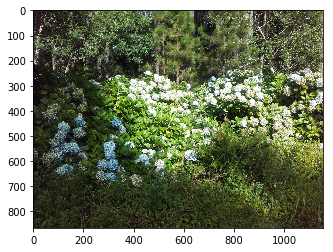

In [8]:
img = plt.imread(f'{PATH}train/{files[0]}')
plt.imshow(img)

In [9]:
img.shape

(866, 1154, 3)

In [10]:
label_csv = f'{PATH}train_labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n, val_pct=0.1)
print("Total training records(n): " + str(n))
print("# of records in the validation set: " + str(len(val_idxs)))

Total training records(n): 2295
# of records in the validation set: 229


In [11]:
label_df = pd.read_csv(label_csv)
label_df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [12]:
label_df.pivot_table(index='invasive', aggfunc=len).sort_values('name', ascending=False)

,name
invasive,
1,1448
0,847


In [13]:
arch = resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train_labels.csv',
                                   test_name='test',
                                   suffix='.jpg',
                                   val_idxs=val_idxs,
                                   tfms=tfms, bs=32)

In [14]:
fn = PATH + data.trn_ds.fnames[1]
fn

'../../data/invspec/train/10.jpg'

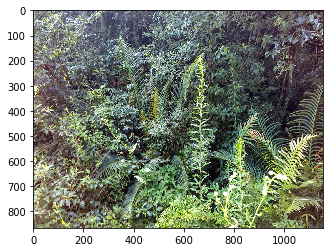

In [16]:
img = plt.imread(fn)
plt.imshow(img)

In [17]:
img.shape

(866, 1154, 3)

In [18]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

## Initial Baseline Model

In [20]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}train_labels.csv',
                                   test_name='test',
                                   suffix='.jpg',
                                   val_idxs=val_idxs,
                                   tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(400, 'tmp')

### Precompute

In [21]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [22]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

### Finding a Learning Rate

In [23]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 40/65 [00:01<00:01, 20.15it/s, loss=2.67] 


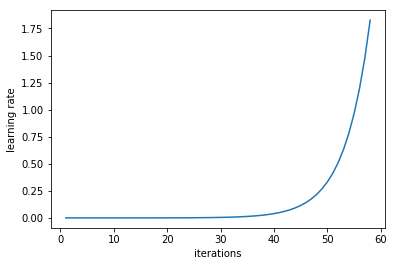

In [24]:
learn.sched.plot_lr()

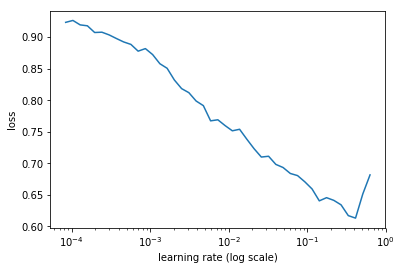

In [25]:
learn.sched.plot()

In [26]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.356333   0.153752   0.914062  
    1      0.254504   0.155034   0.929688                   



[0.15503393, 0.9296875]

### Prediction and Accuracy Analysis of Baseline Model

In [27]:
log_preds, y = learn.TTA() #learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
print("Accuracy of baseline predictions: " + str(accuracy_np(probs, y)))


Accuracy of baseline predictions: 0.9213973799126638


### Confusion Matrix for Baseline Model

In [28]:
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]

[[ 86   9]
 [  9 125]]


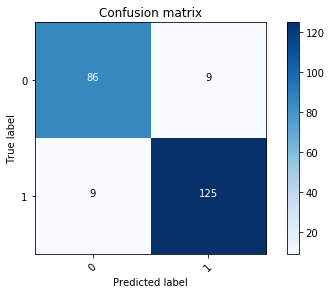

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

### Identifying Wrong Predictions

In [31]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds== data.val_y)==is_correct) & (data.val_y==y), mult)

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


#### A few Correct Labels at random

Correctly Classifies


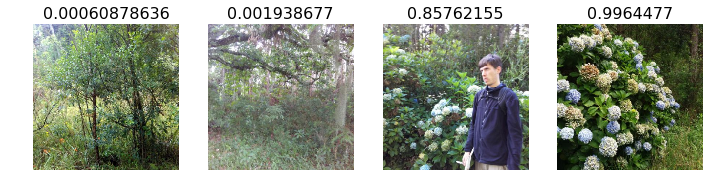

In [32]:
plot_val_with_title(rand_by_correct(True), "Correctly Classifies")

#### A few Incorrect Labels at random

Incorrectly Classifies


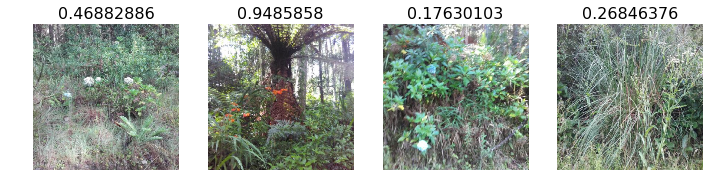

In [33]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classifies")

#### Most Correct Labels

Most Correct


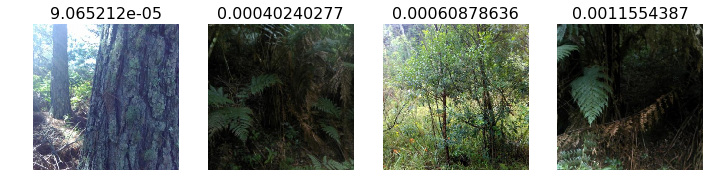

In [34]:
plot_val_with_title(most_by_correct(0, True), "Most Correct")

#### Most Incorrect Labels

Most Incorrect


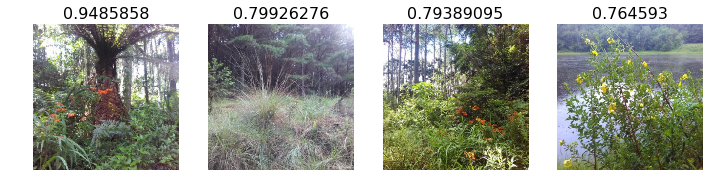

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most Incorrect")

#### Most Uncertain Predictions

Most Uncertain Predictions


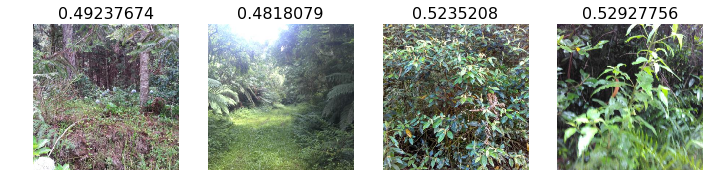

In [37]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most Uncertain Predictions")

### Setting Precompute to False to Improve Learning

In [38]:
learn.precompute=False

In [39]:
learn.fit(1e-2, 3, cycle_len=1) #Cycle_len is Stocastic GD with restarts a varient of learning rate annealing

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.264847   0.22555    0.908594  
    1      0.240374   0.16477    0.908594                  
    2      0.244644   0.199575   0.900781                  



[0.19957533, 0.9007812514901161]

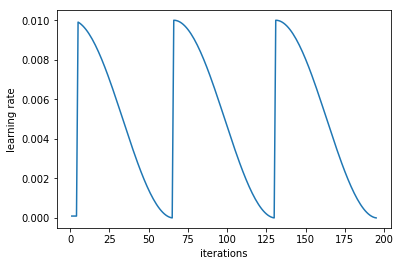

In [40]:
learn.sched.plot_lr()

In [41]:
learn.save('species_34')

In [42]:
learn.load('species_34')

### Fine Tuning and Differential Learning Rate Annealing

In [43]:
learn.unfreeze()

In [44]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [45]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.231246   0.131597   0.953125  
    1      0.160322   0.109532   0.964844                  
    2      0.116588   0.089289   0.96875                   
    3      0.115207   0.090007   0.976562                  
    4      0.094673   0.074799   0.972656                   
    5      0.079208   0.074315   0.976562                   
    6      0.06066    0.070642   0.976562                   



[0.07064178, 0.9765625]

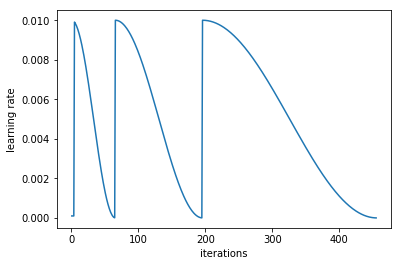

In [46]:
learn.sched.plot_lr()

In [47]:
learn.save('species_34_all')

In [48]:
learn.load('species_34_all')

#### Test Time Augmentation

In [49]:
log_preds, y = learn.TTA()

In [50]:
probs = np.mean(np.exp(log_preds), 0)

In [51]:
accuracy_np(probs, y)

0.9781659388646288

### Analyzing Results

In [52]:
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]

In [53]:
cm = confusion_matrix(y, preds)

[[ 92   3]
 [  2 132]]


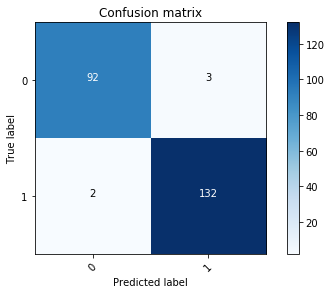

In [54]:
plot_confusion_matrix(cm, data.classes)

Most Incorrect


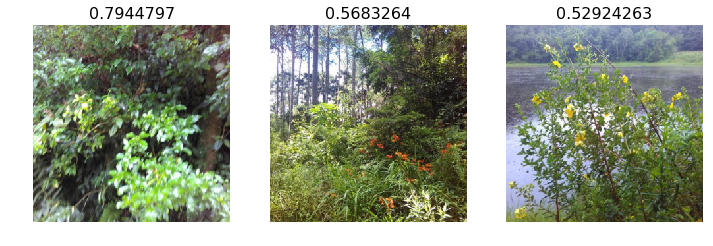

In [55]:
plot_val_with_title(most_by_correct(0, False), "Most Incorrect")

### Making Submission File

In [60]:
log_preds = learn.predict(is_test=True)
probs = np.exp(log_preds)
print(probs.shape)

(1531, 2)


In [64]:
probs

array([[0.00013, 0.99987],
       [0.98543, 0.01457],
       [0.00215, 0.99785],
       ...,
       [0.00096, 0.99904],
       [0.00022, 0.99978],
       [0.9994 , 0.0006 ]], dtype=float32)

In [76]:
sub = pd.DataFrame(probs[:,1])
sub.columns = ['invasive']

In [77]:
test_names = [o[5:-4] for o in data.test_ds.fnames]

In [78]:
sub.insert(0, 'name', test_names)

In [82]:
sub.to_csv('invspecsubm', index=False) #compression='gzip'

In [83]:
FileLink('invspecsubm.csv')

/home/paperspace/fastai/avirepo/invspecsubm.csv

## Performance Summary

* Base model ResNet34
  * Without precomputation: 92.13% accuracy
  * With precomputation: 90.07% accuracy
  * With Differential Learning Rate: 97.65% accuracy
  * With Test Time Augmentation: 97.81% accuracy
  * Submission on the Test Set(without TTA): 98.64% accuracy